In [2]:
import sys
import os
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from PIL import Image
from tensorflow import keras

IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    from google.colab import drive

    drive.mount('/gdrive')
    % cd / gdrive / My Drive / ANNDL-H1 /
    !pip install sklearn
    !pip install visualkeras

import visualkeras
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization
#OUR CUSTOM HELPER CLASS
sys.path.append('../../../Utils/')
from DatasetHelper import *
from ModelHelper import ModelHelper
tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.10.0


In [3]:

dataset_dir = '../../data'
training_dir = os.path.join(dataset_dir, '')

In [5]:
#Create Instances Of Utils Helper
seed = 42
labels = {0:'Species1', 1:'Species2', 2:'Species3', 3:'Species4',4:'Species5', 5:'Species6', 6:'Species7', 7:'Species8'}

#Dataset Helper
dataset_helper = DatasetHelper("../../",42, create_dirs=True) #Take in input dataset folder and random seed

#Model Helper
#SAVE MODEL IN LOCAL, IF MODEL IS GOOD; COPY IT BY HAND TO good_model Folder
model_helper   = ModelHelper("../../",labels) #take in input local models folder and lables
model_helper.create_seed(tf,seed);



In [8]:
#Load Dataset
X,Y = dataset_helper.load_dataset_from_numpy()
dataset_size = X.shape[0]

Extracting data from dataset at: ../../data
Found 3542 images belonging to 8 classes.


100%|██████████| 442/442 [00:16<00:00, 26.07it/s]


In [5]:
#Split Training and Testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=seed, test_size=int(0.1 * dataset_size),stratify = Y)

# Normalize data
X_train = X_train/255.
X_test = X_test/255.

#Split Training and Validation
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, random_state=seed, test_size=int(0.1 * dataset_size),stratify = Y_train)


X_train,Y_train = dataset_helper.apply_data_augmentation_normalized(X_train,Y_train,5000)

[8 7 6 5 4 3 2 1]
Data Augmentation with data distribution
Data distribution = [0.1236076  0.12298875 0.12974224 0.12309638 0.12352688 0.12341925
 0.12306947 0.13054943]


  0%|          | 0/8 [00:00<?, ?it/s]

Class: 1
Class Size : 149
BB
Generating 618.0379917128557Images



 12%|█▎        | 1/8 [00:00<00:06,  1.16it/s]

Class: 2
Class Size : 427
BB
Generating 614.9437658074582Images



 25%|██▌       | 2/8 [00:01<00:05,  1.08it/s]

Class: 3
Class Size : 414
BB
Generating 648.7111876446212Images



 38%|███▊      | 3/8 [00:02<00:04,  1.06it/s]

Class: 4
Class Size : 410
BB
Generating 615.4818920518753Images



 50%|█████     | 4/8 [00:03<00:03,  1.05it/s]

Class: 5
Class Size : 426
BB
Generating 617.634397029543Images



 62%|██████▎   | 5/8 [00:04<00:02,  1.04it/s]

Class: 6
Class Size : 179
BB
Generating 617.0962707851261Images



 75%|███████▌  | 6/8 [00:05<00:01,  1.05it/s]

Class: 7
Class Size : 430
BB
Generating 615.3473604907709Images



 88%|████████▊ | 7/8 [00:06<00:00,  1.02it/s]

Class: 8
Class Size : 407
BB
Generating 652.7471344777483Images



100%|██████████| 8/8 [00:07<00:00,  1.01it/s]


In [6]:
classes, classes_distribution = np.unique(Y, axis=0, return_counts=True)
classes = classes.argmax(1)
classes = classes + 1
print(classes, classes_distribution)

y_pos = np.arange(len(classes))

[8 7 6 5 4 3 2 1] [508 537 222 531 511 515 532 186]


In [7]:
X_train.shape,X_test.shape,X_val.shape

((7620, 96, 96, 3), (354, 96, 96, 3), (354, 96, 96, 3))

In [8]:
Y_train.shape,Y_test.shape,Y_val.shape

((7620, 8), (354, 8), (354, 8))

[8 7 6 5 4 3 2 1]


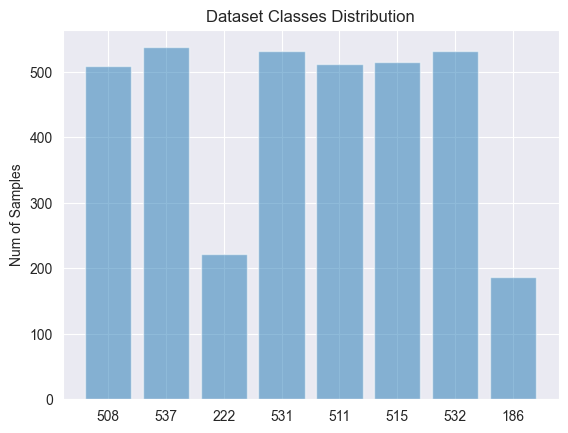

[8 7 6 5 4 3 2 1]


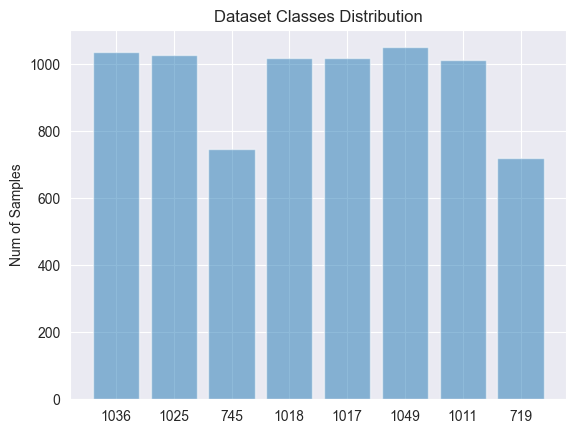

In [9]:
dataset_helper.plot_samples_distribution(Y)
dataset_helper.plot_samples_distribution(Y_train)

In [19]:
input_shape = X_train.shape[1:] # 96*96*3
batch_size = 128
epochs = 50

In [20]:
def build_model(input_shape):
    tf.random.set_seed(seed)

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')
    depth = 4
    start_n_f = 32
    last_layer = input_layer
    for _ in range(depth):
        conv = tfkl.Conv2D(
            filters=start_n_f,
            kernel_size=(3, 3),
            strides = (1, 1),
            padding = 'same',
            activation = None,
            kernel_initializer = tfk.initializers.HeUniform(seed)
        )(last_layer)
        batch = BatchNormalization()(conv)
        activation = tfkl.Activation('relu')(batch)
        pool = tfkl.MaxPooling2D(pool_size = (2, 2))(activation)
        last_layer = pool
        start_n_f *= 2

    flattening_layer = tfkl.Flatten(name='Flatten')(last_layer)
    classifier_layer = tfkl.Dense(
        units=800,
        name='Classifier',
        activation='relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(flattening_layer)
    classifier_layer = tfkl.Dropout(0.5, seed=seed)(classifier_layer)
    output_layer = tfkl.Dense(
        units=8,
        activation='softmax',
        kernel_initializer = tfk.initializers.GlorotUniform(seed),
        name='Output'
    )(classifier_layer)
    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 96, 96, 32)        896       
                                                                 
 batch_normalization_4 (Batc  (None, 96, 96, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 96, 96, 32)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 48, 48, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 48, 48, 64)        18496 

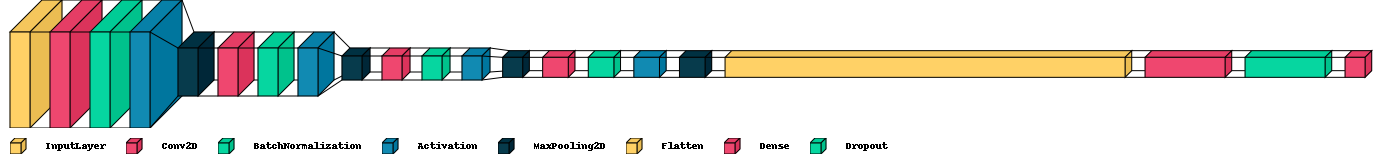

In [21]:
model = build_model(input_shape)
model.summary()
visualkeras.layered_view(model, legend=True, spacing=20, scale_xy=1)

In [22]:
X_val.shape,Y_val.shape

((354, 96, 96, 3), (354, 8))

In [23]:
# Train the model
#%env TF_FORCE_UNIFIED_MEMORY: 1
callbacks_selected = model_helper.createCallbacks(earlyStopping = True,checkPoints=True,patience=25)

#Fit the model
history = model.fit(
    x = X_train,
    y = Y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val, Y_val),
    callbacks = callbacks_selected
).history

history = model.fit(
    x = X_train,
    y = Y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val, Y_val)
).history

Epoch 1/50


2022-11-13 19:38:08.573787: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


60/60 [==============================] - 6s 90ms/step - loss: 5.2679 - accuracy: 0.1837 - val_loss: 2.1698 - val_accuracy: 0.1582
Epoch 2/50


2022-11-13 19:38:14.031033: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


60/60 [==============================] - 5s 88ms/step - loss: 1.9523 - accuracy: 0.2207 - val_loss: 2.1337 - val_accuracy: 0.1525
Epoch 3/50
60/60 [==============================] - 5s 87ms/step - loss: 1.8796 - accuracy: 0.2390 - val_loss: 2.3044 - val_accuracy: 0.1638
Epoch 4/50
60/60 [==============================] - 5s 87ms/step - loss: 1.8395 - accuracy: 0.2663 - val_loss: 1.9651 - val_accuracy: 0.2175
Epoch 5/50
60/60 [==============================] - 5s 87ms/step - loss: 1.7792 - accuracy: 0.2874 - val_loss: 2.0741 - val_accuracy: 0.1102
Epoch 6/50
60/60 [==============================] - 5s 87ms/step - loss: 1.7056 - accuracy: 0.3269 - val_loss: 2.2425 - val_accuracy: 0.1554
Epoch 7/50
60/60 [==============================] - 5s 87ms/step - loss: 1.6607 - accuracy: 0.3440 - val_loss: 3.1667 - val_accuracy: 0.0904
Epoch 8/50
60/60 [==============================] - 5s 87ms/step - loss: 1.6108 - accuracy: 0.3631 - val_loss: 3.5066 - val_accuracy: 0.2090
Epoch 9/50
60/60 [======

In [29]:
model_helper.save_model(model,'model2')

INFO:tensorflow:Assets written to: ../../local_saved_models/model2/assets


INFO:tensorflow:Assets written to: ../../local_saved_models/model2/assets


In [33]:

model = model_helper.load_model('model2')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 96, 96, 32)        896       
                                                                 
 batch_normalization_4 (Batc  (None, 96, 96, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 96, 96, 32)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 48, 48, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 48, 48, 64)        18496 

12/12 [==============================] - 0s 12ms/step


2022-11-13 19:43:33.028372: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


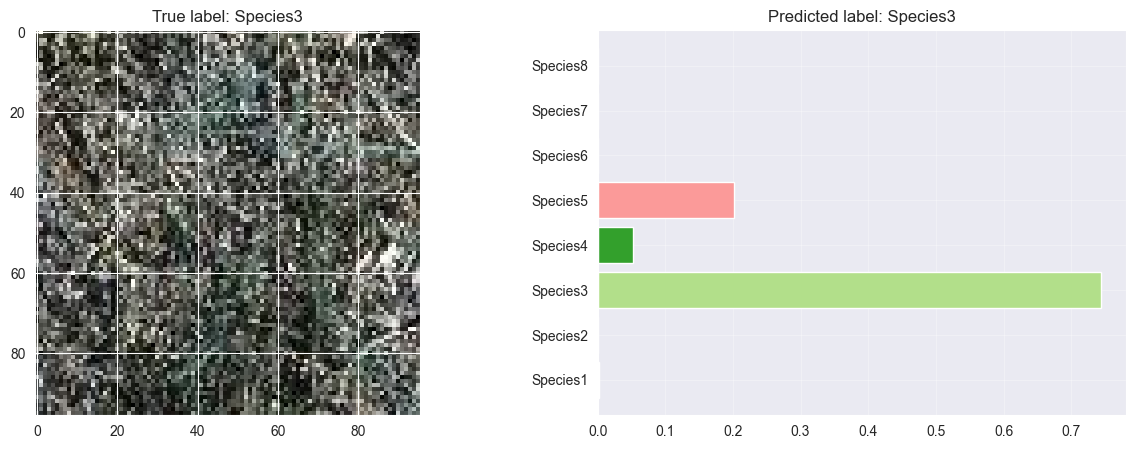

In [26]:
model_helper.show_prediction(X_test,Y_test,1)

BABABA


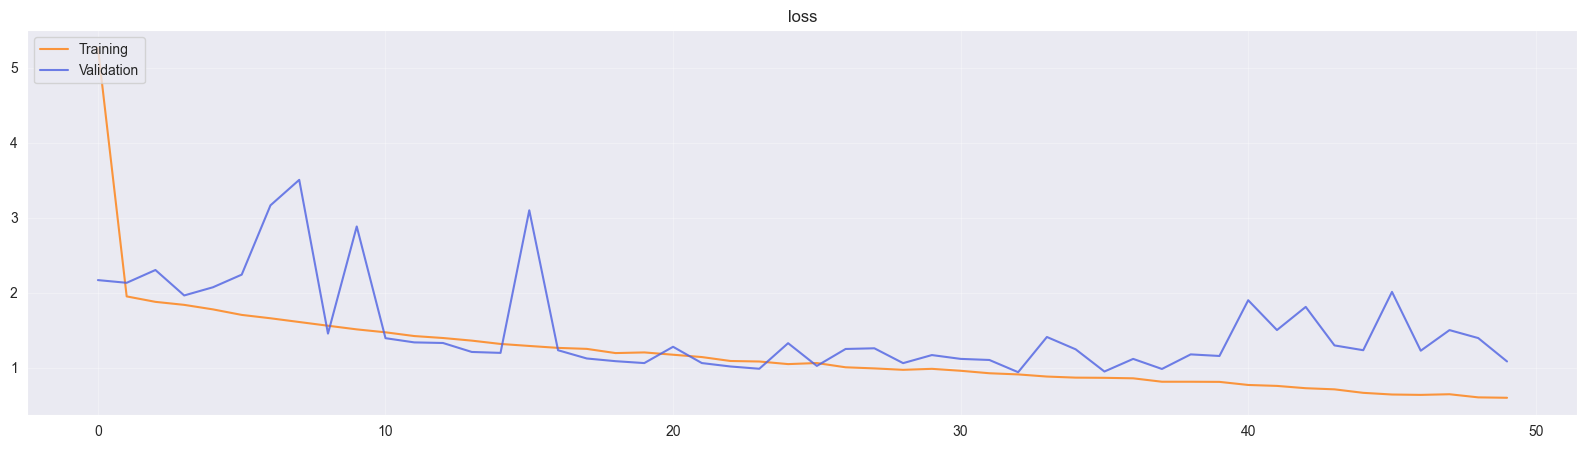

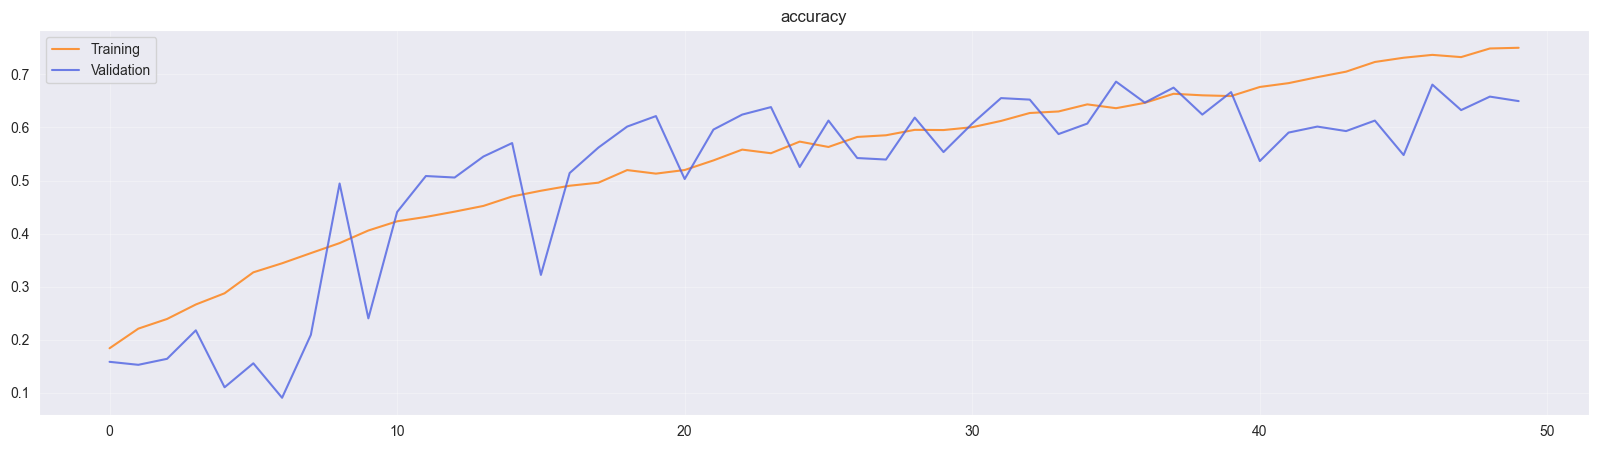

In [27]:
#PLOT THE TRAINING PHASE VS VALIDATION BOTH IN LOSS AND ACCURACY
model_helper.plot_phase_train_vs_validation(history)

12/12 [==============================] - 0s 12ms/step
Accuracy: 0.6836
Precision: 0.6773
Recall: 0.6529
F1: 0.6525


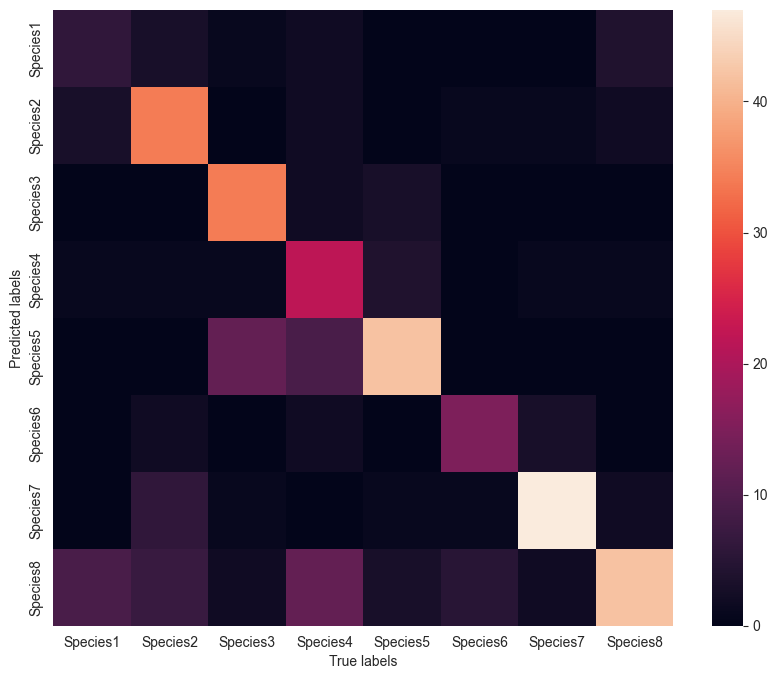

In [28]:
#PLOT CONFUSION MATRIX OF OUR MODEL
#It is good if diagonal has high values and other part of matrix is dark
#Bad if a row has ALL dark cells
#EG species 1 and species 6 has less images in the datase... and here the confusion matrix has all black on them..
model_helper.show_confusion_matrix(X_test,Y_test)

In [70]:
#Submission Model for the challenge -> Path is the folder on the server where our script is
class SubmissionModel:
    def __init__(self, path):
        self.model = tf.keras.models.load_model(os.path.join(path, 'model1'))

    def predict(self, X):

        # Insert your preprocessing here

        out = self.model.predict(X)
        out = np.argmax(out, axis=-1)
        return out

In [ ]:
testing_index = 44
image_to_test = X_test[[testing_index],:]
#image_to_test = X_test[10,None,:]
#image_to_test = np.expand_dims(image_to_test,0)
image_to_test.shape


In [ ]:
print("Real Class: ")
print(labels[np.argmax(Y_test[testing_index])])
tester = SubmissionModel("../../local_saved_models/")
res = tester.predict(image_to_test)
labels[res[0]]

In [ ]:
#Predict all test at oance
predicted_vector = model.predict(X_test)
predicted_vector.shape